# Active Learning Practical

Active Learning is generally useful in a specific case of small data: when unlabelled data is plentiful, but labelling it is costly. Think for example that each example must be analysed by an expert for labelling it. Expert time is costly, so we would like to be able to train a successful classifier while labelling as few examples as possible.

Active Learning is an approach to answer this problem. The general principle is the following: we first randomly ask the expert to label a small random subset of the training data, and train our classifier on it. Once this first step is done, we can analyse the behaviour of our trained model on the yet unlabelled data, to deduce which additional examples would be worth labelling to improve the quality of the model as quickly as possible. We then retrain the model on the new larger labelled dataset and iterate this process, labelling more and more examples, until we reach a satisfying performance. And hopefully reaching it while only labelling a small fraction of the whole available dataset.

The main question in Active Learning is thus the following: How should we choose the next batch of examples to be labelled?

There are different strategies for this, that we will compare in this practical.

### Example setup

We will emulate an active learning situation using the MNIST dataset, starting by pretending we don't have the labels. The "ask an expert to label the example" step will thus be simply picking the label from the dataset.

You'll have to provide a neural network architecture and the implementation of various active learning strategies, with the goal of comparing them. Keep in mind that the start of the training will be on very small datasets when designing your architectures.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

import random

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading MNIST dataset from torchvision.dataset
original_mnist = torchvision.datasets.MNIST(root='data/',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True)

In [3]:
# This function creates an unlabelled dataset based on the MNIST images
#
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[5000:].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[5000:])-1
    )

# This function labels the requested examples on an unlabelled dataset
def call_expert(dataset, indices):
    for i in indices:
        dataset.tensors[1][i] = original_mnist.targets[5000+i]

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

Let's define the model that will be used for the Active learning process:

In [4]:
class FC(nn.Module):
    # Final number of parameters : 28*28*10 = 7840 trainable parameters
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        h = x.view(-1, 28*28)
        output = self.fc1(h)
        
        return output
    
class CNN(nn.Module):
    # Final number of parameters : 104 (Conv) + 1440 = 1544 trainable parameters
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,5) # We use only one convolution to consider the smallest possible model
        self.pool = nn.MaxPool2d(2,2) # We will apply 2 pooling operations in order to downscale the image
        self.fc1 = nn.Linear(4 * 6 * 6, 10) # After downscaling the image, the fully connected has fewer parameters
        
    def forward(self,x):
        x = self.pool(self.pool(F.relu(self.conv1(x))))
        x = x.view(-1, 4 * 6 * 6)
        x = self.fc1(x)
        return x

And here are the learning hyper-parameters, as for the previous practicals you may need to tinker with them:

In [5]:
# number of times the expert will be called to label a batch of examples
num_active_runs = 20

# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
num_iter = 100
batch_size = 32

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1

Now is the place where you define the strategy to choose the next examples to label. A strategy is a function taking as input your model and the dataset, and returning a list of examples to label.

You can create several functions to test different strategies.

In [6]:
def fancy_strategy(model, dataset, nb_request=10, mode='entropy'):
    
    if mode=='random':
        N = len(dataset)
        return torch.randint(0, N, (nb_request,))
    
    # implement your strategies as new functions here
    unlabelled_idx = dataset.tensors[1] < 0
    selected_indexes = torch.nonzero(unlabelled_idx).flatten()
    filtered_dataset = TensorDataset(*list(t[unlabelled_idx] for t in dataset.tensors))
    unlabelled_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=False)
    
    values = torch.zeros(len(filtered_dataset))#unlabelled_idx))
    with torch.no_grad():
        for bth_idx, (data, _) in enumerate(unlabelled_loader):
            try:
                prediction = model(data) # in this case, the linear model doesn't require a reshape
            except:
                prediction = model(data.reshape(-1,1,28,28)) # the convolution operation requires to reshape
            prediction = nn.Softmax(dim=-1)(prediction) # get the prediction socres as a probability
            if mode=='uncertainty':
                best_pred, _ = torch.topk(prediction, 1) # Consider the highest probability for each sample 
                update = - best_pred[:,0]# and select the lowest ones (highest inversed ones)
            elif mode=='entropy':
                update = - torch.sum((prediction * torch.log(prediction)), axis=1)
            elif mode=='deviation':
                best_pred, _ = torch.topk(prediction, 2) # get the two best scores
                update = - torch.abs(best_pred[:,0] - best_pred[:,1]) # compute the difference between those two
                # we want to take the indexes which minimize the deviation so which maximize its opposite (topk)
            else:
                # Could be interesting to get the samples supposed to change the most the global predictions
                RuntimeError('Error: mode not recognized')
                
            values[bth_idx*batch_size: bth_idx*batch_size+len(prediction)] = update
            
    _, indices = torch.topk(values, nb_request)
    
    return selected_indexes[indices]

This function is the main training loop, the only part you should need to modify is the initialization of the optimizer (noted by the `# OPTIMIZER` comment).

Don't forget to reload this cell whenever you change the hyper-parameters.

In [9]:
# returns a tensor of values:
# - output[:,0] are the number of labeled examples
# - output[:,1] are the associated accuracies
# - output[:,2] are the associated losses
def active_training(strategy, model=FC, retrain=False, dataset=None, initial_labeling=20, 
                    nb_request=10, freq_print=5):
    if dataset is None:
        dataset = unlabeled_dataset()
        if type(initial_labeling)==int:
            to_label = torch.randint(0, len(dataset), (initial_labeling,))
        else:
            to_label = initial_labeling
        call_expert(dataset, to_label)
    
    def train_model(model, optimizer, loader, epochs):
        for _ in range(epochs):
            for (data, targets) in loader:
                model.zero_grad()
                try:
                    prediction = model(data)
                except:
                    prediction = model(data.reshape(-1,1,28,28))
                loss = criterion(prediction, targets)
                loss.backward()
                optimizer.step()
    
    def validation_perf(model, dataset):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        total_accuracy = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for (data, targets) in loader:
                try:
                    prediction = model(data)
                except:
                    prediction = model(data.reshape(-1,1,28,28))
                total_loss += criterion(prediction, targets).item() * data.size(0)
                _, number_predicted = torch.max(prediction.data, 1)
                total_accuracy += (number_predicted == targets).sum()
        return (total_accuracy / len(dataset), total_loss / len(dataset))
    
    performances = torch.zeros(num_active_runs+1, 3)
    if not retrain:
        model = model()
    else:
        loaded = False
    local_lr = learning_rate
    for i in range(num_active_runs+1):
        # filter the dataset to only keep labelled examples
        labelled_idx = dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=False)
        # create a new model to train on this dataset
        if retrain and not loaded:
            model = model()
            loaded = True
        else:
            # if we don't retrain, then we need to decrease the learning rate with the training
            if i%8==7:
                local_lr = local_lr/10
        # OPTIMIZER
        optimizer = torch.optim.SGD(model.parameters(), lr=local_lr)
        train_model(model, optimizer, loader, num_iter // len(loader))
        (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
        
        performances[i, 0] = len(filtered_dataset)
        performances[i, 1] = valid_acc
        performances[i, 2] = valid_loss
        
        if i%freq_print==0:
            print("With {} examples, valid perf is: Loss = {:.4f} -- Val_Acc = {:.2f}%".format(
                                            len(filtered_dataset), valid_loss, valid_acc*100))
        
        if i < num_active_runs:
            to_label = fancy_strategy(model, dataset, nb_request, mode=strategy)
            call_expert(dataset, to_label)
    
    return performances

---

In [10]:
# a list of strategies you want to compare
strategies = ['random','uncertainty','deviation','entropy']
# number of examples to label randomly at the start
initial_labeling = 100
nb_request=15

perf_no_retrain_diff_init = []
for strat in strategies:
    for model_class in [FC, CNN]:
        print('-'*70)
        print("Training {} with strategy: {}".format(model_class.__name__, strat))#.__name__))
        perf = active_training(strat, model=model_class, retrain=False,
                               initial_labeling=initial_labeling, nb_request=nb_request)
        perf_no_retrain_diff_init.append((strat, perf))#.__name__, perf))
print("done")

----------------------------------------------------------------------
Training FC with strategy: random
With 100 examples, valid perf is: Loss = 1.0205 -- Val_Acc = 69.68%
With 175 examples, valid perf is: Loss = 0.7220 -- Val_Acc = 79.28%
With 250 examples, valid perf is: Loss = 0.7179 -- Val_Acc = 78.88%
With 324 examples, valid perf is: Loss = 0.6319 -- Val_Acc = 80.84%
With 398 examples, valid perf is: Loss = 0.5968 -- Val_Acc = 81.84%
----------------------------------------------------------------------
Training CNN with strategy: random
With 100 examples, valid perf is: Loss = 0.5526 -- Val_Acc = 81.74%
With 175 examples, valid perf is: Loss = 0.4974 -- Val_Acc = 87.16%
With 250 examples, valid perf is: Loss = 0.4979 -- Val_Acc = 88.02%
With 325 examples, valid perf is: Loss = 0.4276 -- Val_Acc = 89.14%
With 400 examples, valid perf is: Loss = 0.4097 -- Val_Acc = 89.78%
----------------------------------------------------------------------
Training FC with strategy: uncertainty

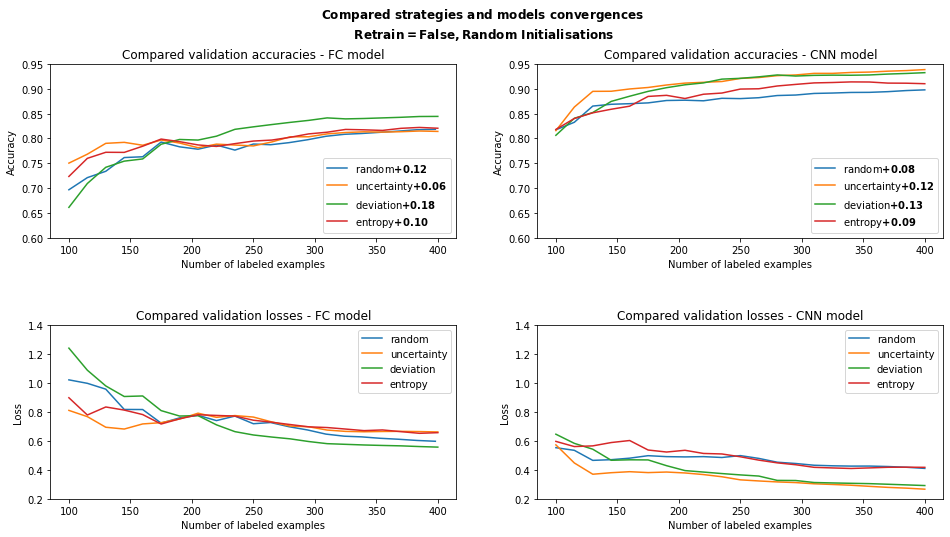

In [18]:
plt.figure(figsize=(16,8))
plt.suptitle('$\mathbf{Compared\ strategies\ and\ models\ convergences}$\n $\mathbf{Retrain=False, Random\ Initialisations}$')
plt.subplots_adjust(hspace=0.5)

model_perf = [perf_no_retrain_diff_init[::2], perf_no_retrain_diff_init[1::2]]
for index, model_class in enumerate([FC, CNN]):
    plt.subplot(221+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,1], label=name+'$ \mathbf{+ %.2f}$' % (perf[:,1][-1] - perf[:,1][0]))
    plt.title("Compared validation accuracies - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.ylim(0.6,0.95)
    
    plt.subplot(223+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,2], label=name)
    plt.title("Compared validation losses - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.ylim(0.2,1.4)
plt.show()

---
**What if we retrain the model from scratch at each step ?**

In [12]:
# a list of strategies you want to compare
strategies = ['random','uncertainty','deviation','entropy']
# number of examples to label randomly at the start
initial_labeling = 100
nb_request=15

perf_retrain_diff_init = []
for strat in strategies:
    for model_class in [FC, CNN]:
        print('-'*70)
        print("Training {} with strategy: {}".format(model_class.__name__, strat))#.__name__))
        perf = active_training(strat, model=model_class, retrain=True,
                               initial_labeling=initial_labeling, nb_request=nb_request)
        perf_retrain_diff_init.append((strat, perf))#.__name__, perf))
print("done")

----------------------------------------------------------------------
Training FC with strategy: random
With 100 examples, valid perf is: Loss = 1.0721 -- Val_Acc = 71.46%
With 174 examples, valid perf is: Loss = 0.7426 -- Val_Acc = 79.08%
With 248 examples, valid perf is: Loss = 0.7184 -- Val_Acc = 79.76%
With 323 examples, valid perf is: Loss = 0.6412 -- Val_Acc = 81.58%
With 397 examples, valid perf is: Loss = 0.6320 -- Val_Acc = 81.86%
----------------------------------------------------------------------
Training CNN with strategy: random
With 99 examples, valid perf is: Loss = 0.6031 -- Val_Acc = 81.72%
With 174 examples, valid perf is: Loss = 0.5239 -- Val_Acc = 86.40%
With 249 examples, valid perf is: Loss = 0.4777 -- Val_Acc = 87.86%
With 324 examples, valid perf is: Loss = 0.4476 -- Val_Acc = 88.52%
With 398 examples, valid perf is: Loss = 0.4387 -- Val_Acc = 88.92%
----------------------------------------------------------------------
Training FC with strategy: uncertainty


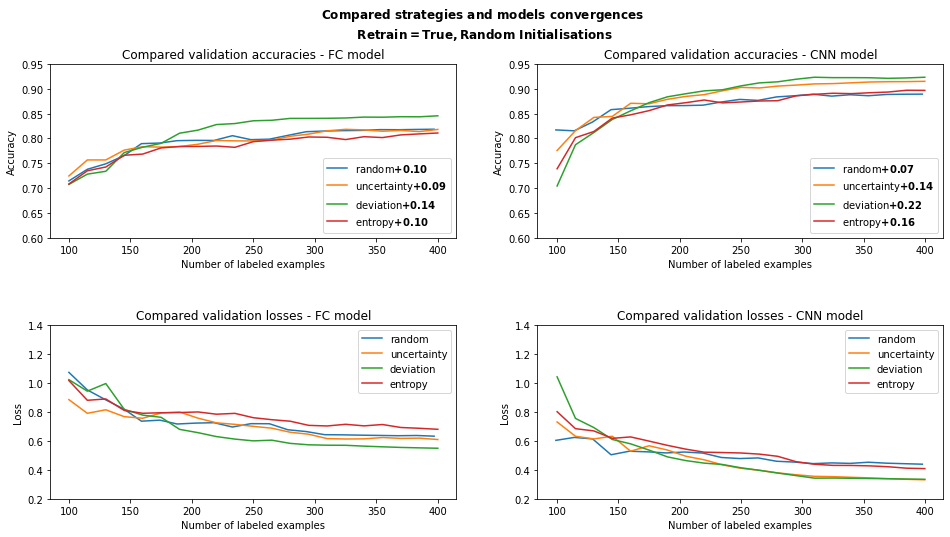

In [17]:
plt.figure(figsize=(16,8))
plt.suptitle('$\mathbf{Compared\ strategies\ and\ models\ convergences}$\n $\mathbf{Retrain=True, Random\ Initialisations}$')
plt.subplots_adjust(hspace=0.5)

model_perf = [perf_retrain_diff_init[::2], perf_retrain_diff_init[1::2]]
for index, model_class in enumerate([FC, CNN]):
    plt.subplot(221+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,1], label=name+'$ \mathbf{+ %.2f}$' % (perf[:,1][-1] - perf[:,1][0]))
    plt.title("Compared validation accuracies - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.ylim(0.6,0.95)
    
    plt.subplot(223+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,2], label=name)
    plt.title("Compared validation losses - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.ylim(0.2,1.4)
plt.show()

---

**It might be much better to give the same initialisation to each strategy :**

In [14]:
# a list of strategies you want to compare
strategies = ['random','uncertainty','deviation','entropy']
# number of examples to label randomly at the start
initial_labeling = torch.randint(0, 55000, (100,))
nb_request=15

perf_no_retrain_same_init = []
for strat in strategies:
    for model_class in [FC, CNN]:
        print('-'*70)
        print("Training {} with strategy: {}".format(model_class.__name__, strat))#.__name__))
        perf = active_training(strat, model=model_class, retrain=False,
                               initial_labeling=initial_labeling, nb_request=nb_request)
        perf_no_retrain_same_init.append((strat, perf))#.__name__, perf))
print("done")

----------------------------------------------------------------------
Training FC with strategy: random
With 100 examples, valid perf is: Loss = 0.9416 -- Val_Acc = 71.96%
With 175 examples, valid perf is: Loss = 0.8121 -- Val_Acc = 77.58%
With 250 examples, valid perf is: Loss = 0.8108 -- Val_Acc = 77.62%
With 324 examples, valid perf is: Loss = 0.7389 -- Val_Acc = 78.90%
With 398 examples, valid perf is: Loss = 0.7122 -- Val_Acc = 80.00%
----------------------------------------------------------------------
Training CNN with strategy: random
With 100 examples, valid perf is: Loss = 0.7885 -- Val_Acc = 76.64%
With 174 examples, valid perf is: Loss = 0.7555 -- Val_Acc = 83.22%
With 249 examples, valid perf is: Loss = 0.7213 -- Val_Acc = 84.70%
With 324 examples, valid perf is: Loss = 0.6134 -- Val_Acc = 86.04%
With 399 examples, valid perf is: Loss = 0.5876 -- Val_Acc = 86.56%
----------------------------------------------------------------------
Training FC with strategy: uncertainty

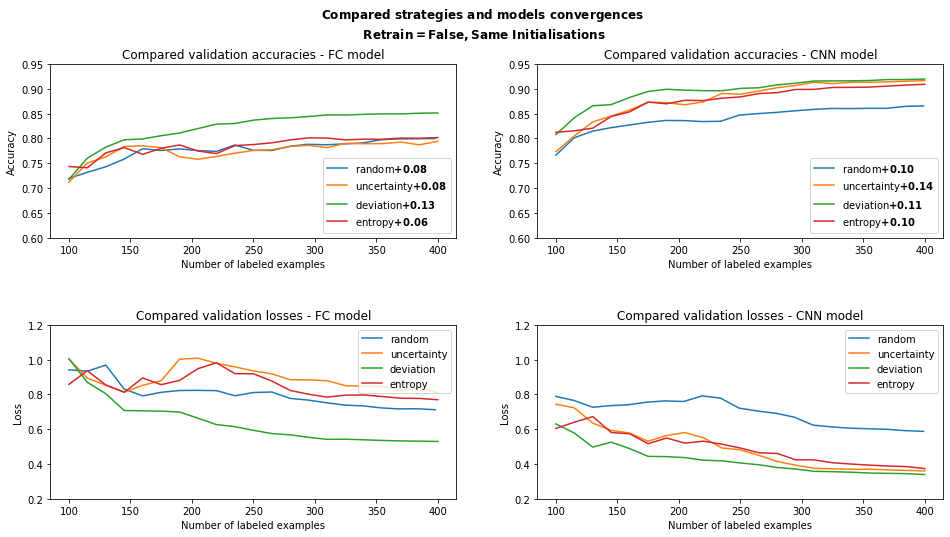

In [19]:
plt.figure(figsize=(16,8))
plt.suptitle('$\mathbf{Compared\ strategies\ and\ models\ convergences}$\n $\mathbf{Retrain=False, Same\ Initialisations}$')
plt.subplots_adjust(hspace=0.5)

model_perf = [perf_no_retrain_same_init[::2], perf_no_retrain_same_init[1::2]]
for index, model_class in enumerate([FC, CNN]):
    plt.subplot(221+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,1], label=name+'$ \mathbf{+ %.2f}$' % (perf[:,1][-1] - perf[:,1][0]))
    plt.title("Compared validation accuracies - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.ylim(0.6,0.95)
    
    plt.subplot(223+index)
    for (name, perf) in model_perf[index]:
        plt.plot(perf[:,0], perf[:,2], label=name)
    plt.title("Compared validation losses - {} model".format(model_class.__name__))
    plt.xlabel("Number of labeled examples")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.ylim(0.2,1.2)
plt.show()

---
---
---

**Conclusion :**
> The network has a huge impact on the perfomance and the impact of the strategy. 
- Using a convolutional network works impressively well at first and thus the uncertainty startegy works well on it. Moreover, as we implemented it we have fewer parameters with it than with the simplest fully convolutional network. This way we try to make sure that we won't overfit on the data. Using 100 first examples and updating with requests of 15 samples until 400 examples yields a final result between **0.90** and **0.95** with the considered strategies.
- Using a fully connected network (with 5 times more trainable parameters compared to the CNN) has a strange conclusion : the random strategy is not that bad ! 

> Retraining the model from scratch has an impact on each strategies' impact. If we retrain from scratch, then each weird sample on which the previous model wasn't sure will have the same importance as any other observation. However, if we don't retrain the model then it is somehow finetuned on the weird touchy data. But then the model might overfit on the data it sees again and again. Thus we decided to decrease the learning rate 2 times during the training dividing it by 10 each time.
 - Retraining from scratch yields a little bit worst results but it doesn't change much.
 
> It could have been interesting to have a look at the impact of each and every parameter such as the learning rate, the batch size, number of updates, initial size of the dataset and size of each update. However, we have tried them on our own and didn't return it here since it is not the main objective of this lab. Indeed we wanted to feel a bit what happens here and to improve the baseline of 0.90 in accuracy with 500 samples. Interestingly, the random strategy when retraining from scratch actually provides us with a baseline for each model : their respective perfomance with a standard number of samples selected randomly and not with a fancy strategy. Thus, it is very satisfying to notice that each model is above the random curve at each step ! This is somehow a proof of concept of active learning !

**Finally, our best strategy in each case is the deviation strategy. One might thought that it would be the entropy one that would yield the best results but in fact probably that it selects samples that are too much uncertain with respect with all classes, whereas the deviation only selects samples near the decision boundary between two classes. For instance, it should select elements that look like a 3 or an 8 (close) whereas the entropy strategy selects samples that a mixture of all classes (less impactful to have their true target).**

---

**To go further we would have liked to :**
- display the corresponding selected images to assess whether our interpretation is true. This should also have enabled us to visualize in a different way the differences between each strategy and explain the differences between them.
- Find a way to implement the strategy based on selecting the samples which should modify the most the weights and the algorithm (the most perturbating observations). This was the final strategy presented in class and might thus yield the best results if implemented properly (which isn't crystal clear).